In [2]:
import numpy as np
import random
import time, os

from IPython.display import clear_output
from collections import deque
import progressbar

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import leaky_relu
from IPython.display import clear_output

from matplotlib import pyplot as plt

In [3]:
class Deep_pitcher:
    def __init__(self, enviroment, optimizer):
        
        # Initialize atributes
        self._state_size = enviroment.observation_space_n
        self._action_size = enviroment.action_space_n
        self._optimizer = optimizer
        
        self.expirience_replay = deque(maxlen=2000)
        
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 0.5
        self.pure_random_epsilon = 0.05
        #self.lr_rate = 0.81
        
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.alighn_target_model()

    def store(self, state, action, reward, next_state, terminated):
        self.expirience_replay.append((state, action, reward, next_state, terminated))
    
    def change_eps(self, ch_up = True):
        if ch_up :
            if self.epsilon <= 0.8:      ##最高只能有 0.8 亂試
                self.epsilon += 0.005       ##動態增加psilon
        else:
            if self.epsilon >= 0.2:      ##最低還是有 0.2 會亂試
                self.epsilon -= 0.005   ##動態降低epsilon
    
    def _build_compile_model(self):
        model = Sequential()
        model.add(Embedding(self._state_size, 10, input_length=1))
        model.add(Reshape((10,)))
        model.add(Dropout(0.25))
        model.add(Dense(10, kernel_initializer='normal', activation=leaky_relu))
        model.add(Dropout(0.25))
        model.add(Dense(10, kernel_initializer='normal', activation=leaky_relu))
        model.add(Dense(self._action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=self._optimizer)
        return model

    def alighn_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state, close_epsilon=False):
        if (not close_epsilon) and np.random.rand() <= self.epsilon:
            return enviroment.action_sample()
        elif np.random.rand() <= self.pure_random_epsilon:
            return enviroment.action_sample()
        
        q_values = self.q_network.predict(state)
        return np.argmax(q_values[0])

    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            
            target = self.q_network.predict(state)
            
            if terminated:
                target[0][action] = reward
            else:
                pred_val_arr = self.target_network.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(pred_val_arr)
            
            self.q_network.fit(state, target, epochs=1, verbose=0)
            
    def CS_poker_face(self):
        for i in range(12):
            target = self.q_network.predict( [i] )
            print(i, ":", target)

In [4]:
class Agent:
    def __init__(self, enviroment, optimizer):
        
        # Initialize atributes
        self._state_size = enviroment.observation_space_n
        self._action_size = enviroment.action_space_n
        self._optimizer = optimizer
        
        self.expirience_replay = deque(maxlen=2000)
        
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 0.5
        self.pure_random_epsilon = 0.05
        #self.lr_rate = 0.81
        
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.alighn_target_model()

    def store(self, state, action, reward, next_state, terminated):
        self.expirience_replay.append((state, action, reward, next_state, terminated))
    
    def change_eps(self, ch_up = True):
        if ch_up :
            if self.epsilon <= 0.8:      ##最高只能有 0.8 亂試
                self.epsilon += 0.005        ##動態增加psilon
        else:
            if self.epsilon >= 0.2:      ##最低還是有 0.2 會亂試
                self.epsilon -= 0.005    ##動態降低epsilon
        
    def _build_compile_model(self):
        model = Sequential()
        model.add(Embedding(self._state_size, 10, input_length=1))
        model.add(Reshape((10,)))
        model.add(Dense(10, kernel_initializer='normal', activation=leaky_relu))
        model.add(Dropout(0.25))
        model.add(Dense(10, kernel_initializer='normal', activation=leaky_relu))
        model.add(Dense(self._action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=self._optimizer)
        return model

    def alighn_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state, close_epsilon=False):
        if (not close_epsilon) and np.random.rand() <= self.epsilon:
            return enviroment.action_sample()
        
        #elif np.random.rand() <= self.pure_random_epsilon:
        #    return enviroment.action_sample()
        
        q_values = self.q_network.predict(state)
        return np.argmax(q_values[0])

    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            
            target = self.q_network.predict(state)
            
            if terminated:
                target[0][action] = reward
            else:
                pred_val_arr = self.target_network.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(pred_val_arr)
            
            self.q_network.fit(state, target, epochs=1, verbose=0)
            
    def CS_poker_face(self):
        for i in range(12):
            target = self.q_network.predict( [i] )
            print(i, ":", target)

In [5]:
class Baseball_Field():
    
    def __init__(self):
        #[0B0S, 0B1S, 0B2S, 
        # 1B0S, 1B1S, 1B2S, 
        # 2B0S, 2B1S, 2B2S, 
        # 3B0S, 3B1S, 3B2S]
        self.observation_space_n = 12
        #for Q_table[  Hold, Swing_IH, Swing_IL, Swing_OH, Swing_OL] 
        #for P_table[B_ball, G_ball_IH, G_ball_IL, G_ball_OH, G_ball_OL, ]
        self.action_space_n = 5  
        self.state = 0
        #state = 0 ~ 11 will keep play, state = 12:OUT,13:WALK,14:HIT
        #Pitcher_strategy_tendency
        
    def reset(self):
        self.state = 0
        return self.state
    
    def action_sample(self):
        #np.random.uniform(0, 4)
        rd_action = random.choice([0,4])
        return rd_action
        
    def step(self, Q_action, P_action):
        info = ""
        HIT_BALL_LUCKY_NUM = 0.5
        reward_adder = 0
        pitcher_reward = 0
        next_state = -1
        state_for_p = np.reshape(self.state, [1, 1])
        if P_action == 0:    #P-B_ball
            if Q_action == 0:             #P-B_ball, Q-Hold, so add a bad ball
                next_state = {
                    0 :  3,  1 :  4,  2 :  5,  
                    3 :  6,  4 :  7,  5 :  8,
                    6 :  9,  7 : 10,  8 : 11, 
                    9 : 13, 10 : 13, 11 : 13
                }.get(self.state,'step_change_state_error1.')  #{12:OUT,13:WALK,14:HIT}
                reward_adder = 1    #little-good-move
                pitcher_reward = -1
                
            elif (Q_action >= 1) and (Q_action <= 4):   #P-B_ball, Q-Swing, Air-swing, so add a good ball
                next_state = {
                    0 :  1,  1 :  2,  2 : 12,  
                    3 :  5,  4 :  5,  5 : 12,
                    6 :  7,  7 :  8,  8 : 12, 
                    9 : 10, 10 : 11, 11 : 12
                }.get(self.state,'step_change_state_error1.')  #{12:OUT,13:WALK,14:HIT}
                reward_adder = -3    #little-bad-move
                pitcher_reward = 1
                
            else:
                print('step_Q_action_error_when_P0.')
                
        elif (P_action >= 1) and (P_action <= 4):    #P-G_ball
            if Q_action == 0:             #Q-Hold, so add a good ball
                next_state = {
                    0 :  1,  1 :  2,  2 : 12,  
                    3 :  5,  4 :  5,  5 : 12,
                    6 :  7,  7 :  8,  8 : 12, 
                    9 : 10, 10 : 11, 11 : 12
                }.get(self.state,'step_change_state_error1.')  #{12:OUT,13:WALK,14:HIT}
                reward_adder = -1    #little-bad-move
                pitcher_reward = 1
                
            elif (Q_action == P_action) and np.random.uniform(0, 1) <= HIT_BALL_LUCKY_NUM:   
                next_state = 14     #Q-Swing, Lucky Hit-the-Ball!!
                reward_adder = 5    #little-good-move
                pitcher_reward = -1
                info = 'Hit-good'
                
            elif (Q_action == P_action) :   ##P-G_ball, Q-Swing, sadly bad-Hit!!
                next_state = {
                    0 :  1,  1 :  2,  2 : 12,  
                    3 :  5,  4 :  5,  5 : 12,
                    6 :  7,  7 :  8,  8 : 12, 
                    9 : 10, 10 : 11, 11 : 12
                }.get(self.state,'step_change_state_error1.')  #{12:OUT,13:WALK,14:HIT}
                reward_adder = 5    #little-good-move
                pitcher_reward = -15
                info = 'Hit-good'
            
            elif (Q_action >= 1) and (Q_action <= 4):   ##P-G_ball, Q-Swing, but Air-swing, so add a good ball
                next_state = {
                    0 :  1,  1 :  2,  2 : 12,  
                    3 :  5,  4 :  5,  5 : 12,
                    6 :  7,  7 :  8,  8 : 12, 
                    9 : 10, 10 : 11, 11 : 12
                }.get(self.state,'step_change_state_error1.')  #{12:OUT,13:WALK,14:HIT}
                reward_adder = -2    #little-bad-move
                pitcher_reward = 1
                
            else:
                print('step_Q_action_error_when_P1.')
                
        else:
            print('step_P_table_error.')
        
        reward = 0
        reward += reward_adder

        done = 0
        
        if next_state == 12:
            done = 1
            info = 'StrikeOut'
            next_state = 0
            reward -= 10
            pitcher_reward +=10
            
        elif next_state == 13:
            done = 1
            info = 'Walk'
            next_state = 0
            reward += 5
            pitcher_reward += -5
            
        elif next_state == 14:
            done = 1
            info = 'Hit-good'
            next_state = 0
            reward += 5
            pitcher_reward += -15
            
        elif next_state < 0:
            print('state_change_error_unknown.')
            
        else:  #still in game
            done = 0
        
        self.state = next_state
        
        return self.state, reward, pitcher_reward, done, info
    

In [6]:
#FrozenLake-v0
#Taxi-v3
enviroment = Baseball_Field()
optimizer = Adam(learning_rate=0.01)

new_pitcher = Deep_pitcher(enviroment, optimizer)

agent = Agent(enviroment, optimizer)

print('new_pitcher:')
new_pitcher.q_network.summary()
print('================================')

print('agent batter:')
agent.q_network.summary()
print('================================')

print('Number of states : {}'.format(enviroment.observation_space_n))
print('Number of actions: {}'.format(enviroment.action_space_n))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
new_pitcher:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             120       
_________________________________________________________________
reshape (Reshape)            (None, 10)                0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                110       
___________________

#### 驗證用function

In [7]:
def tmp_test_func( test_eps = 1000):
    is_b_close = True
    is_p_close = True

    batch_size = 32
    test_episodes = test_eps
    timesteps_per_episode = 100

    total_score = 0
    pp_total_score = 0

    hit_good_times = 0
    strike_out_times = 0
    walk_times = 0
    
    per_episode_reward_list = []
    accumulate_reward_list = []
    pp_per_episode_reward_list = []
    pp_accumulate_reward_list = []
    accumulate_episode_list = []

    for episode in range(0, test_episodes):
        # Reset the enviroment
        state = enviroment.reset()
        state = np.reshape(state, [1, 1])

        # Initialize variables
        episode_reward = 0
        pp_episode_reward = 0
        reward = 0
        p_reward = 0
        terminated = False

        for timestep in range(timesteps_per_episode):
            # Run Action
            action = agent.act(state, close_epsilon=is_b_close)
            p_action = new_pitcher.act(state, close_epsilon=is_p_close)

            # Take action
            next_state, reward, p_reward, terminated, info = enviroment.step(action, p_action) 
            next_state = np.reshape(next_state, [1, 1])
            if(not is_b_close):
                agent.store(state, action, reward, next_state, terminated)
            if(not is_p_close):
                new_pitcher.store(state, p_action, p_reward, next_state, terminated)

            state = next_state
            episode_reward += reward
            pp_episode_reward += p_reward

            if terminated:
                break

        if info == 'Hit-good':
            hit_good_times += 1
        elif info == 'StrikeOut':
            strike_out_times += 1
        elif info == 'Walk':
            walk_times += 1

        total_score += episode_reward
        pp_total_score += pp_episode_reward
        
        per_episode_reward_list.append(episode_reward)
        accumulate_reward_list.append(total_score)
        pp_per_episode_reward_list.append(pp_episode_reward)
        pp_accumulate_reward_list.append(pp_total_score)
        accumulate_episode_list.append(episode)

        if (episode + 1) % 200 == 0:
            print("test Ep:", episode)

    print("")
    print("==================================")
    print("使用的超參數:")
    print("agent epsilon =", agent.epsilon)
    print("pitcher epsilon =", new_pitcher.epsilon)
    print("gamma =", agent.gamma)
    print("----------------------------------")
    print("hit_good_times:", hit_good_times)
    print("strike_out_times :", strike_out_times)
    print("walk_times    :", walk_times)
    print("----------------------------------")
    print("total_episode:", (episode+1))
    print("total_score  :", total_score)
    print("average_score:", total_score/(episode+1))
    print("pp_total_score  :", pp_total_score)
    print("avg pp_total_score  :", pp_total_score/(episode+1))
    print("==================================")
    
    print("每一個 Episode 的 Reward:")
    plt.xlabel('each <Episode>')
    plt.ylabel('each <Reward>')
    plt.title('Each rewards per episode ')
    plt.plot(accumulate_episode_list, per_episode_reward_list, color='r',label = 'per_episode reward')
    plt.legend()
    plt.show()
    print("")

    print("隨著 Episode 增加累積的 Reward:")
    plt.xlabel('accumulated <Episode>')
    plt.ylabel('accumulated <Reward>')
    plt.title('Total rewards change with episode')
    plt.plot(accumulate_episode_list, accumulate_reward_list, color='b',label = 'accumulated reward')
    plt.legend()
    plt.show()
    print("")

    print("每一個 Episode 的 PPP_Reward:")
    plt.xlabel('each <Episode>')
    plt.ylabel('each <ppp Reward>')
    plt.title('Each ppp rewards per episode ')
    plt.plot(accumulate_episode_list, pp_per_episode_reward_list, color='g',label = 'pp per_episode reward')
    plt.legend()
    plt.show()
    print("")

    print("隨著 Episode 增加累積的 PPP_Reward:")
    plt.xlabel('each <Episode>')
    plt.ylabel('accumulated <ppp Reward>')
    plt.title('Total ppp rewards change with episode')
    plt.plot(accumulate_episode_list, pp_accumulate_reward_list, color='purple',label = 'pp accumulated reward')
    plt.legend()
    plt.show()
    print("")
    
    print("=================================================")
    print("怕甲 Bat")
    print("i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL")
    agent.CS_poker_face()
    print("=================================================")
    print("披甲 Pch")
    print("i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL")
    new_pitcher.CS_poker_face()
    print("=================================================")
    
    return hit_good_times, strike_out_times, walk_times

#### 練爽的

>>Ep: 299
test Ep: 199
test Ep: 399
test Ep: 599
test Ep: 799
test Ep: 999

使用的超參數:
agent epsilon = 0.8000000000000003
pitcher epsilon = 0.19999999999999973
gamma = 0.6
----------------------------------
hit_good_times: 0
strike_out_times : 973
walk_times    : 27
----------------------------------
total_episode: 1000
total_score  : -9695
average_score: -9.695
pp_total_score  : 9695
avg pp_total_score  : 9.695
每一個 Episode 的 Reward:


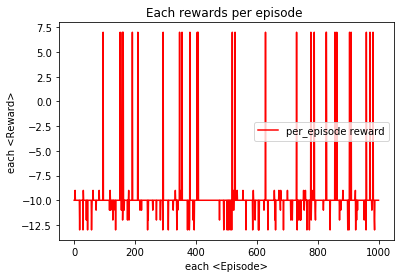


隨著 Episode 增加累積的 Reward:


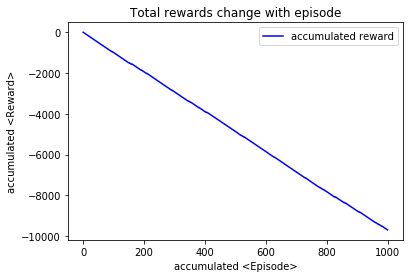


每一個 Episode 的 PPP_Reward:


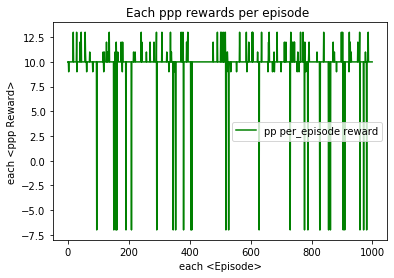


隨著 Episode 增加累積的 PPP_Reward:


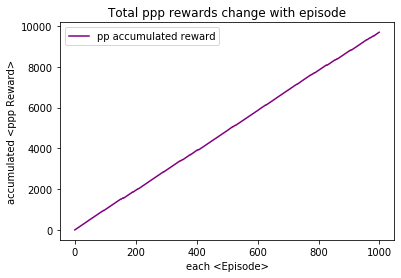


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-0.85883915 -2.9741144  -3.9941132  -3.877551   -1.890979  ]]
1 : [[-0.765337  -2.8687809 -3.9021673 -3.7543728 -1.9473794]]
2 : [[-1.4879103 -3.4685206 -6.589222  -6.5946965 -8.044765 ]]
3 : [[-0.8442465 -3.0779936 -3.9757133 -3.8583784 -1.8115542]]
4 : [[-0.78927195 -2.9056635  -3.99677    -3.8020039  -2.2763321 ]]
5 : [[-1.5955268 -3.4012885 -6.4264836 -6.479608  -7.350838 ]]
6 : [[-0.86490774 -2.877345   -4.082281   -4.095123   -1.8062656 ]]
7 : [[-0.5354019 -2.538251  -3.9071116 -3.7200298 -2.4961052]]
8 : [[-1.632162  -3.5749345 -6.57508   -6.5980606 -7.762145 ]]
9 : [[-1.4520917 -3.2561193 -6.0354366 -6.044588  -6.6071196]]
10 : [[-0.5275534 -2.688321  -3.8563447 -3.8799374 -1.1254345]]
11 : [[-0.07097241 -2.5568626  -4.124615   -3.8927217  -3.8282614 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 3.1155534   4.4937644  -1.6037165  -0.85176367 -0.08307379]]
1 : [[ 3.156801    4.502204

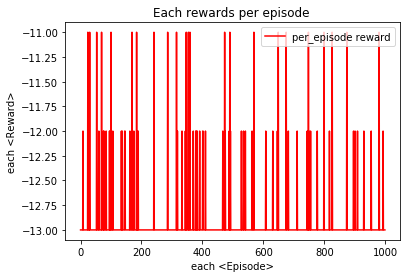


隨著 Episode 增加累積的 Reward:


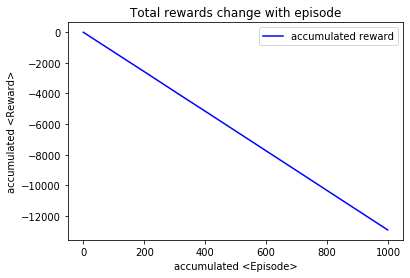


每一個 Episode 的 PPP_Reward:


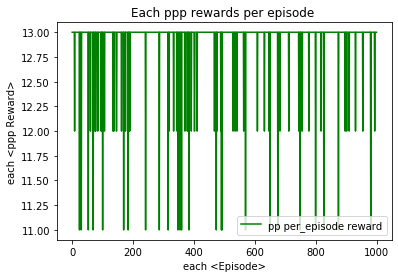


隨著 Episode 增加累積的 PPP_Reward:


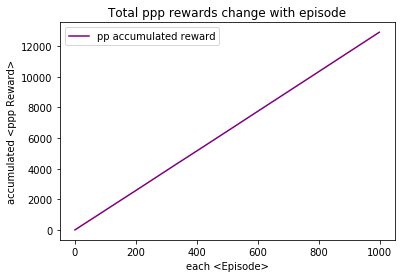


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.6469338 -5.1194115 -4.635304  -3.4969957 -2.8325114]]
1 : [[-3.2321525 -5.5215464 -5.291996  -3.9777288 -4.9107504]]
2 : [[ -5.5329204 -10.752714  -12.256826  -11.196066  -12.365337 ]]
3 : [[-2.593247  -5.0822635 -4.582568  -3.4763174 -2.916571 ]]
4 : [[-3.1275856 -5.4537706 -5.1794243 -3.89501   -4.4895883]]
5 : [[ -4.9220786  -9.569937  -10.645658   -9.55257   -10.5439205]]
6 : [[-2.4074225 -4.954984  -4.386489  -3.328143  -2.3104067]]
7 : [[-2.912103  -5.3625736 -4.9848614 -3.774311  -4.2408667]]
8 : [[-3.759665  -5.7147126 -5.717719  -4.1754403 -5.7097855]]
9 : [[-3.191715  -5.5000896 -5.257291  -3.9496002 -4.5418944]]
10 : [[-2.4903767 -5.0434895 -4.532926  -3.418652  -2.5131693]]
11 : [[-3.9499528 -5.732779  -5.8710976 -4.210105  -5.778343 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[5.349691   6.4231286  5.1179595  5.360794   0.63556826]]
1 : [[5.0725555 7.8661056 4.333939  5.0925

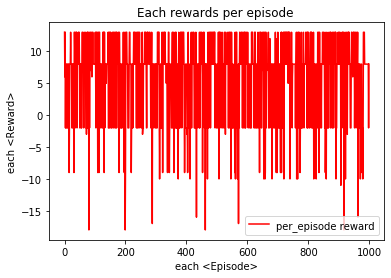


隨著 Episode 增加累積的 Reward:


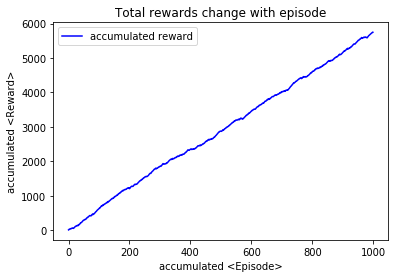


每一個 Episode 的 PPP_Reward:


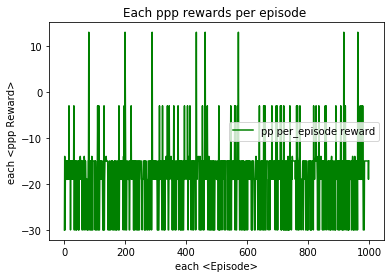


隨著 Episode 增加累積的 PPP_Reward:


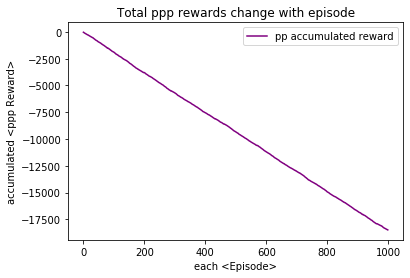


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.2598863  -0.47871798 -5.238031   -4.190764   -3.2165256 ]]
1 : [[-3.5976596  -0.83398473 -5.7208214  -4.4903183  -5.3596234 ]]
2 : [[ -7.56679    -7.9121428 -10.098794   -5.992849   -9.18665  ]]
3 : [[-2.8372076  -0.13189375 -5.4638624  -4.586389   -4.290398  ]]
4 : [[-1.6985735  0.8781811 -5.195135  -4.6708584 -2.9628215]]
5 : [[-3.3124268 -1.0882237 -5.357136  -4.2121673 -4.476098 ]]
6 : [[-1.1513109  0.9958339 -5.2771425 -4.728957  -2.1720943]]
7 : [[-2.2366233  -0.14441597 -5.294041   -4.385391   -3.3052363 ]]
8 : [[-4.4954085 -1.4361312 -6.4032907 -4.750893  -7.2014594]]
9 : [[-2.6996574 -0.9542985 -5.164772  -3.995582  -3.5791018]]
10 : [[-1.802755    0.41228777 -5.260211   -4.554514   -2.8367043 ]]
11 : [[-4.2980585 -1.1552668 -6.194927  -4.6188784 -6.7109337]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[4.463596  4.5127926 4.619331  4.366792  0.3250476]]
1 : [[5.2519674 6.024674  4

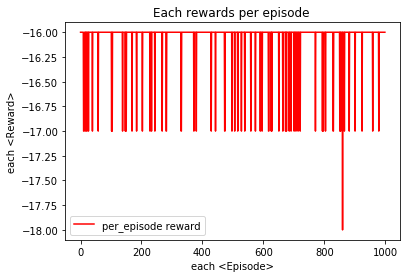


隨著 Episode 增加累積的 Reward:


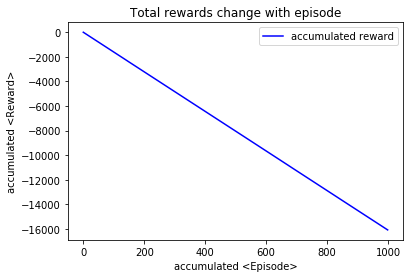


每一個 Episode 的 PPP_Reward:


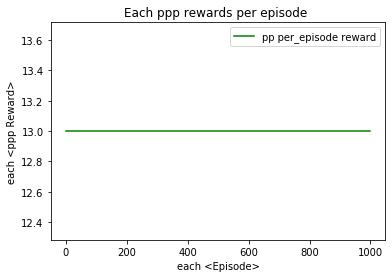


隨著 Episode 增加累積的 PPP_Reward:


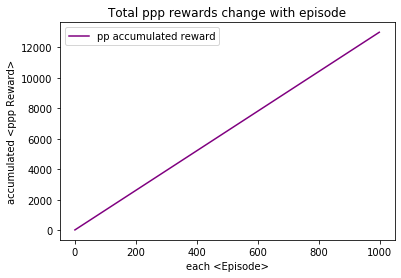


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-3.4200292 -2.2545097 -5.6145577 -5.321277  -3.5754309]]
1 : [[-4.7739897 -2.1154735 -5.551325  -5.176298  -5.107046 ]]
2 : [[ -9.937201   -9.108821   -8.60041    -7.0369396 -10.283408 ]]
3 : [[-4.349022  -2.057297  -5.54292   -5.2015514 -4.6137524]]
4 : [[-4.65096   -2.4326346 -5.6750154 -5.362837  -4.701692 ]]
5 : [[-9.354375 -8.489234 -8.324854 -6.89149  -9.636808]]
6 : [[-2.4504406 -2.8351407 -5.8438406 -5.629114  -2.44131  ]]
7 : [[-4.478798  -1.8904433 -5.5017023 -5.1149397 -4.862232 ]]
8 : [[-10.005207   -8.758658   -8.465553   -6.9186783 -10.48101  ]]
9 : [[-3.017693  -1.746717  -5.442299  -5.0932302 -3.5280883]]
10 : [[-2.2138705 -2.3046927 -5.6889195 -5.4214034 -2.5306416]]
11 : [[-6.5103607 -2.3984075 -5.7311583 -5.3454413 -6.874011 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.105647   3.751109   4.686557   4.608446  -1.0887078]]
1 : [[ 5.043466   5.2877655  5.5267124  5.70317

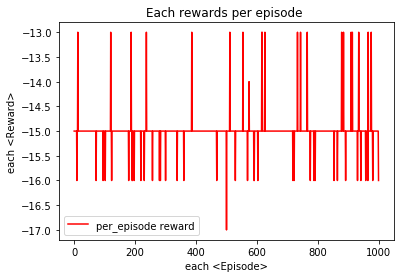


隨著 Episode 增加累積的 Reward:


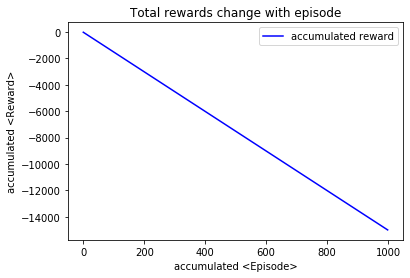


每一個 Episode 的 PPP_Reward:


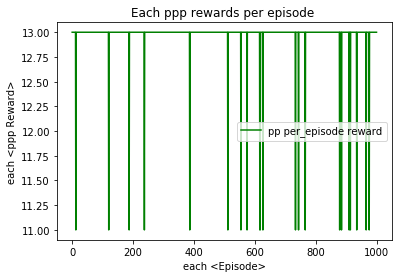


隨著 Episode 增加累積的 PPP_Reward:


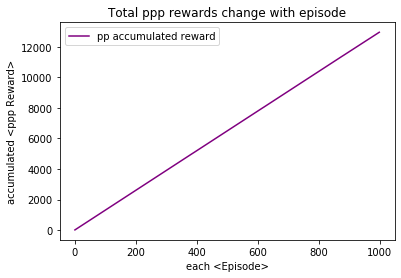


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.8867295 -4.031756  -5.9752264 -6.0717287 -4.223243 ]]
1 : [[-4.558092  -3.176662  -5.98281   -6.1195884 -5.1604524]]
2 : [[-10.413429   -9.120044   -8.653153   -8.0333805 -10.053063 ]]
3 : [[-4.202755  -2.9310207 -5.8677783 -5.929924  -4.8260765]]
4 : [[-3.3101563 -3.5731032 -5.90762   -5.984221  -4.3737674]]
5 : [[-5.4316263 -3.03127   -6.048243  -6.102626  -5.8100643]]
6 : [[-3.3274882 -6.030538  -6.2916994 -6.6352916 -2.8040576]]
7 : [[-3.8622234 -5.262335  -6.270072  -6.9328737 -5.3096075]]
8 : [[-9.622434  -8.094023  -8.2496805 -7.765374  -9.456349 ]]
9 : [[-3.9943206 -3.2341897 -5.8667326 -6.02368   -4.81304  ]]
10 : [[-3.860787  -5.0641503 -6.1240177 -6.40957   -3.0720375]]
11 : [[-6.956972  -3.1785662 -5.8257213 -6.352033  -6.916126 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.5745335  3.318082   4.962323   4.6705236 -1.4563199]]
1 : [[ 5.132606   3.8110008  5.47891    5.38084

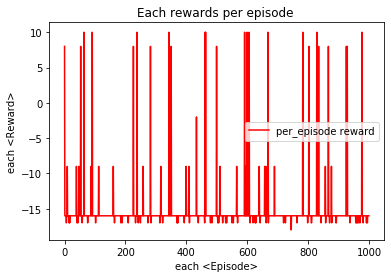


隨著 Episode 增加累積的 Reward:


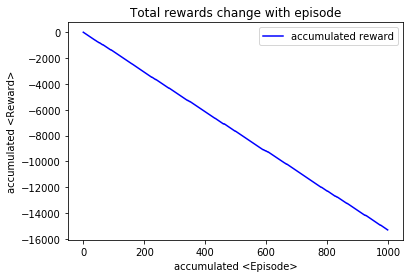


每一個 Episode 的 PPP_Reward:


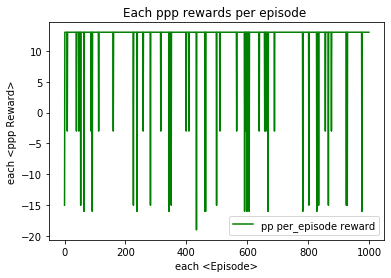


隨著 Episode 增加累積的 PPP_Reward:


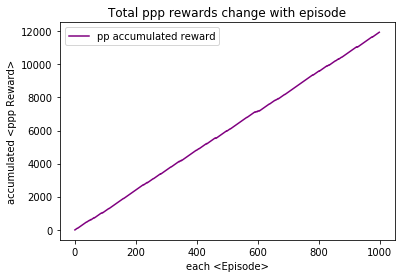


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-3.936146  -4.2140236 -2.6132407 -6.9744725 -1.7650859]]
1 : [[-3.8824296 -4.1824164 -2.7582703 -6.8586917 -1.9813097]]
2 : [[-6.9338913 -8.626801  -5.801859  -6.156123  -9.286487 ]]
3 : [[-4.073741  -4.050748  -2.5700521 -6.807799  -1.6076977]]
4 : [[-4.100107  -3.96662   -2.555097  -6.736945  -1.6100543]]
5 : [[-7.383054  -9.181037  -5.2165527 -7.0703425 -9.026302 ]]
6 : [[-4.4132366  -4.9987392  -1.499316   -9.363892    0.37537456]]
7 : [[-3.988715  -4.5483584 -2.0195632 -7.910495  -1.3880742]]
8 : [[-3.0877862 -3.9924839 -4.3006306 -6.024323  -3.5327892]]
9 : [[-4.1206765 -4.052368  -2.506124  -7.0283475 -1.4999259]]
10 : [[-4.0287275 -4.315995  -2.2197711 -7.541221  -1.373219 ]]
11 : [[ -4.0969224  -5.2695127 -11.721845    1.8087382 -13.648695 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.373214   4.142278   5.6074147  5.818217  -2.8176982]]
1 : [[ 4.159299   3.899747   5.7023344  6.

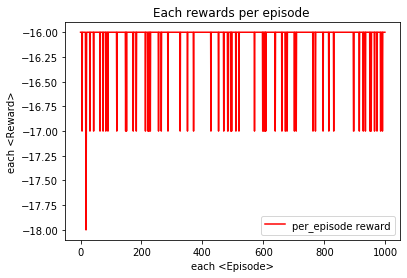


隨著 Episode 增加累積的 Reward:


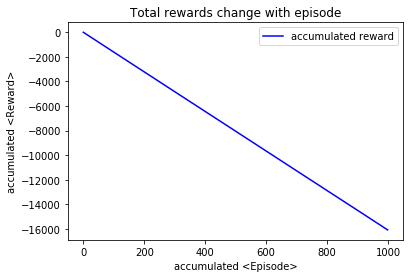


每一個 Episode 的 PPP_Reward:


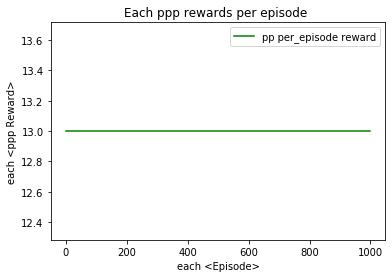


隨著 Episode 增加累積的 PPP_Reward:


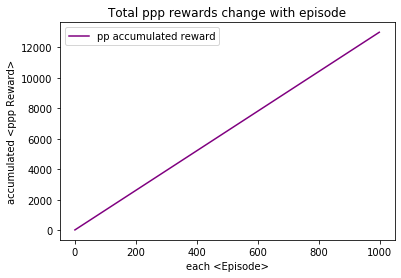


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.9935799 -4.8472624 -1.6109502 -8.112219  -2.6998823]]
1 : [[-3.4853063 -4.8191457 -2.3704433 -8.162794  -3.0834036]]
2 : [[ -9.015598   -4.6855593  -8.436913  -12.181692  -10.912981 ]]
3 : [[-2.7615051 -6.1111917  0.7452924 -8.44911   -1.0347452]]
4 : [[-3.7738986 -5.4417014 -1.7825043 -8.414987  -2.5959554]]
5 : [[ -8.783934   -5.2791595  -7.3022356 -12.186756   -9.913145 ]]
6 : [[-2.7086267 -4.48625   -1.9314293 -8.027302  -3.014345 ]]
7 : [[-3.5373702 -5.2817354 -1.7885091 -8.378775  -2.7145483]]
8 : [[-4.312301  -4.5138936 -3.9211547 -8.145099  -3.9045703]]
9 : [[-3.1784272 -4.486916  -2.4462457 -8.020412  -3.218422 ]]
10 : [[-3.84821   -4.3582053 -3.6764836 -8.126642  -3.9675694]]
11 : [[-3.473243  -4.577003  -3.1765559 -8.259905  -3.6285052]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.2562165  5.1005087  5.21169    5.9857445 -4.0537024]]
1 : [[ 4.732518   4.458763   5.709381   6.

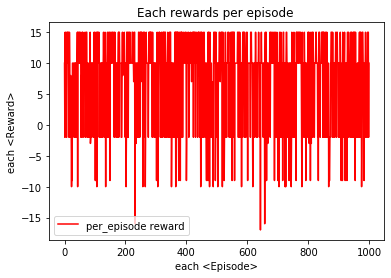


隨著 Episode 增加累積的 Reward:


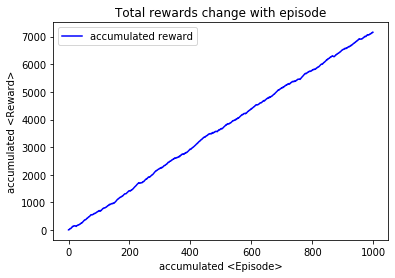


每一個 Episode 的 PPP_Reward:


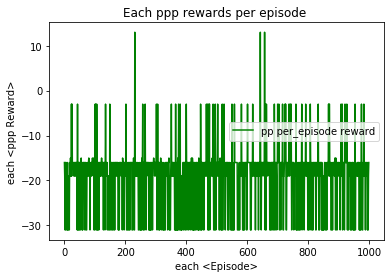


隨著 Episode 增加累積的 PPP_Reward:


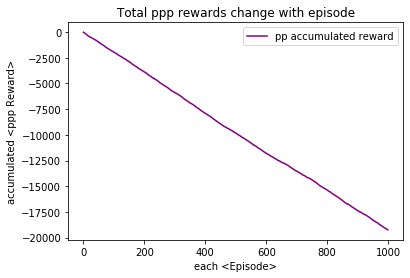


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.1369355  -5.4088225  -1.6466029   0.28585076 -2.2325003 ]]
1 : [[-2.2024853  -5.3979907  -1.7933183   0.11298275 -2.3192787 ]]
2 : [[-10.345527   -8.137561  -10.207831   -3.8136582  -9.748041 ]]
3 : [[-2.3483448  -5.438096   -2.0346174  -0.13061547 -2.4767694 ]]
4 : [[-1.9066081  -5.378065   -1.2123293   0.80093646 -1.9607887 ]]
5 : [[-10.165128  -8.101782  -9.813262  -3.425943  -9.490594]]
6 : [[-1.7652704  -5.3602324  -1.0977839   0.87205267 -1.8365657 ]]
7 : [[-2.2414448 -5.516431  -1.6739882  0.3978727 -2.2610607]]
8 : [[-10.7235155  -8.21166   -11.050336   -4.6443567 -10.298031 ]]
9 : [[-1.9835416  -5.3547244  -1.4044217   0.49977756 -2.0920503 ]]
10 : [[-1.8325975  -5.309131   -1.0661622   0.86476564 -1.8806269 ]]
11 : [[-10.524698   -7.8258176 -12.318124   -6.9218874 -10.675681 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.359076   4.753544   4.645941   4.788565  -3.3079345]]
1 

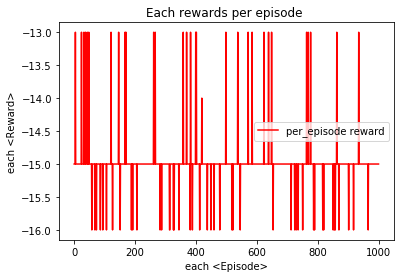


隨著 Episode 增加累積的 Reward:


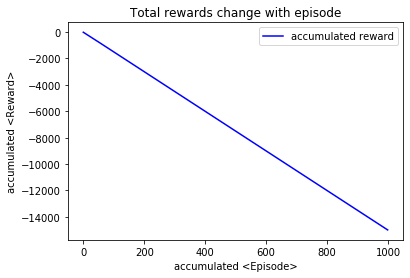


每一個 Episode 的 PPP_Reward:


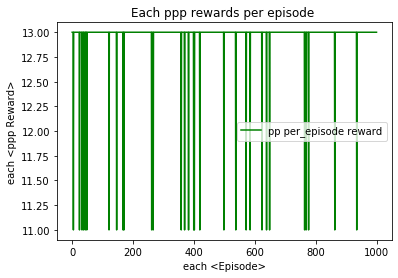


隨著 Episode 增加累積的 PPP_Reward:


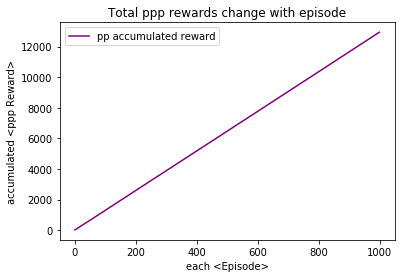


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.3418636 -6.2045617 -4.5067    -2.7532852 -3.2358005]]
1 : [[-3.5912547 -6.1775336 -4.6607943 -2.1998675 -4.8804655]]
2 : [[-10.065363 -10.595579 -12.049387  -6.136409 -11.866527]]
3 : [[-3.5411286 -6.1973476 -4.6247444 -2.2070274 -4.8530073]]
4 : [[-3.5736108 -6.1667137 -4.654623  -2.1746585 -4.865739 ]]
5 : [[ -8.752045   -9.788282  -10.612133   -5.416374  -10.4411335]]
6 : [[-2.3434534 -6.291097  -4.462907  -2.7984843 -3.2745442]]
7 : [[-1.6076572 -5.4245453 -4.63824   -3.747684  -1.7017894]]
8 : [[-10.51029   -10.672695  -12.32596    -6.2333865 -12.377506 ]]
9 : [[-2.6716197 -6.4722586 -4.5268946 -2.8087883 -3.7459574]]
10 : [[-3.841366  -6.219455  -4.740083  -2.2155406 -5.1848445]]
11 : [[ -8.681638   -9.563675  -10.30959    -5.149039  -10.3970585]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 3.9222715   5.228678    5.994235    3.47359    -0.14789462]]
1 : [[4.6731405e+00 6.1696997e+0

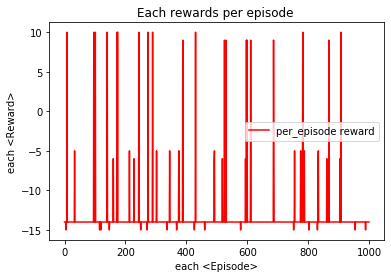


隨著 Episode 增加累積的 Reward:


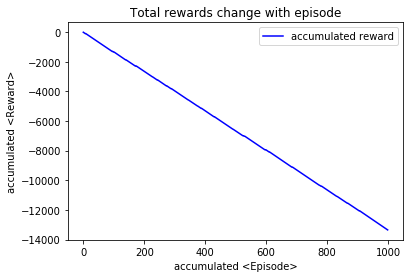


每一個 Episode 的 PPP_Reward:


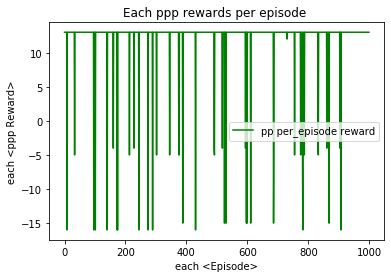


隨著 Episode 增加累積的 PPP_Reward:


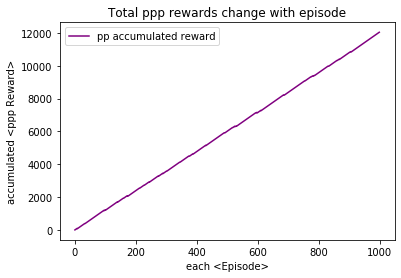


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-3.5095477 -5.372217  -5.8289413 -4.3114715 -4.3764215]]
1 : [[-3.8606803 -5.3401737 -5.978114  -4.4183507 -4.524296 ]]
2 : [[-9.732608  -5.4822955 -9.338676  -8.555061  -8.960367 ]]
3 : [[-3.9780774 -5.302378  -6.000248  -4.4252186 -4.5360093]]
4 : [[-4.0434103 -5.2955008 -6.077183  -4.4193983 -4.5602274]]
5 : [[-9.786184  -5.4912086 -9.260238  -8.555992  -8.94109  ]]
6 : [[-3.5947547 -5.398842  -5.5500317 -4.225498  -4.233939 ]]
7 : [[-3.5060601 -5.3540974 -6.9637394 -4.443117  -4.6949224]]
8 : [[-10.326896   -5.5655074  -9.428277   -8.85475    -9.288281 ]]
9 : [[-4.063779  -5.371668  -5.771304  -4.529767  -4.5404577]]
10 : [[-4.161267  -5.339607  -6.0538673 -4.4981327 -4.615446 ]]
11 : [[-10.9821005  -5.652793  -10.446907   -9.493032  -10.192423 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[5.587194   5.6261206  5.4594893  4.6564217  0.49278593]]
1 : [[5.6193323  6.421559   5.8927636  4.4

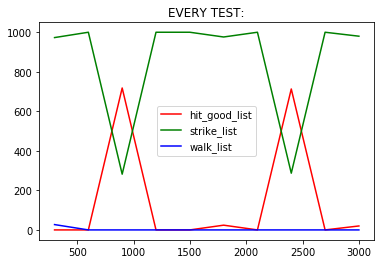

In [8]:
is_b_close = False
is_p_close = False

train_episodes = 3200
test_eps_gap = 300
batch_size = 32
timesteps_per_episode = 100

total_score = 0
pp_total_score = 0

hit_good_times = 0
strike_out_times = 0
walk_times = 0

FnTest_GOOD_LIST = []
FnTest_STRIKE_LIST = []
FnTest_WALK_LIST = []
FnTest_EPS_LIST = []

#per_episode_reward_list = []
#accumulate_reward_list = []
#pp_per_episode_reward_list = []
#pp_accumulate_reward_list = []
#hit_good_list = []
#strike_list = []
#walk_list = []
#accumulate_episode_list = []

for episode in range(0, train_episodes):
    # Reset the enviroment
    state = enviroment.reset()
    state = np.reshape(state, [1, 1])
    
    # Initialize variables
    episode_reward = 0
    pp_episode_reward = 0
    reward = 0
    p_reward = 0
    terminated = False
    
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(state, close_epsilon=is_b_close)
        p_action = new_pitcher.act(state, close_epsilon=is_p_close)
        
        # Take action
        next_state, reward, p_reward, terminated, info = enviroment.step(action, p_action) 
        next_state = np.reshape(next_state, [1, 1])
        if(not is_b_close):
            agent.store(state, action, reward, next_state, terminated)
        if(not is_p_close):
            new_pitcher.store(state, p_action, p_reward, next_state, terminated)
        
        state = next_state
        episode_reward += reward
        pp_episode_reward += p_reward
                
        if terminated:
            if(not is_b_close):
                agent.alighn_target_model()
            if(not is_p_close):
                new_pitcher.alighn_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            if(not is_b_close):
                agent.retrain(batch_size)
            if(not is_p_close):
                new_pitcher.retrain(batch_size)
    
    if info == 'Hit-good':
        agent.change_eps(ch_up = False)
        new_pitcher.change_eps(ch_up = True)
        hit_good_times += 1
    elif info == 'StrikeOut':
        agent.change_eps(ch_up = True)
        new_pitcher.change_eps(ch_up = False)
        strike_out_times += 1
    elif info == 'Walk':
        agent.change_eps(ch_up = False)
        new_pitcher.change_eps(ch_up = True)
        walk_times += 1
        
    total_score += episode_reward
    pp_total_score += pp_episode_reward
    
    #per_episode_reward_list.append(episode_reward)
    #accumulate_reward_list.append(total_score)
    #pp_per_episode_reward_list.append(pp_episode_reward)
    #pp_accumulate_reward_list.append(pp_total_score)
    
    #hit_good_list.append(hit_good_times)
    #strike_list.append(strike_out_times)
    #walk_list.append(walk_times)
    
    #accumulate_episode_list.append(episode)
    
    if (episode +1) % test_eps_gap == 0:
        print(">>Ep:", episode)
        '''
        print("=================================================")
        print("怕甲 Bat")
        print("i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL")
        agent.CS_poker_face()
        print("=================================================")
        print("披甲 Pch")
        print("i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL")
        new_pitcher.CS_poker_face()
        print("=================================================")
        '''
        ### ad some test
        gd, stk, wk = tmp_test_func()
        FnTest_GOOD_LIST.append(gd)
        FnTest_STRIKE_LIST.append(stk)
        FnTest_WALK_LIST.append(wk)
        FnTest_EPS_LIST.append(episode)
        ###

print("=================================================")
print("END WHOLE")
print("=================================================")
print("")
print("使用的超參數:")
print("agent epsilon =", agent.epsilon)
print("pitcher epsilon =", new_pitcher.epsilon)
print("gamma =", agent.gamma)
print("")

print("----------------------------------")
print("hit_good_times:", hit_good_times)
print("strike_out_times :", strike_out_times)
print("walk_times    :", walk_times)
print("----------------------------------")
print("total_episode:", (episode+1))
print("total_score  :", total_score)
print("average_score:", total_score/(episode+1))
print("----------------------------------")
print("")

'''
print("每一個 Episode 的 Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <Reward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, per_episode_reward_list, color='r',label = 'per_episode reward')
plt.legend()
plt.show()
print("")

print("隨著 Episode 增加累積的 Reward:")
plt.xlabel('accumulated <Episode>')
plt.ylabel('accumulated <Reward>')
plt.title('Total rewards change with episode')
plt.plot(accumulate_episode_list, accumulate_reward_list, color='b',label = 'accumulated reward')
plt.legend()
plt.show()
print("")

print("每一個 Episode 的 PPP_Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <ppp Reward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, pp_per_episode_reward_list, color='g',label = 'pp per_episode reward')
plt.legend()
plt.show()
print("")

print("隨著 Episode 增加累積的 PPP_Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <ppp accReward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, pp_accumulate_reward_list, color='purple',label = 'pp accumulated reward')
plt.legend()
plt.show()
print("")


print("每一個......................:")
plt.xlabel('each <Episode>')
plt.ylabel('each <For Fun>')
plt.title('aaaaaaaaaaaaaaaaaaaaaa')
plt.plot(accumulate_episode_list, hit_good_list, color='r',label = 'hit_good_list')
plt.plot(accumulate_episode_list, strike_list, color='g',label = 'strike_list')
plt.plot(accumulate_episode_list, walk_list, color='b',label = 'walk_list')
plt.legend()
plt.show()
print("")
'''

print("==================================")
print("EVERY TEST:")
plt.title('EVERY TEST:')
plt.plot(FnTest_EPS_LIST, FnTest_GOOD_LIST, color='r',label = 'hit_good_list')
plt.plot(FnTest_EPS_LIST, FnTest_STRIKE_LIST, color='g',label = 'strike_list')
plt.plot(FnTest_EPS_LIST, FnTest_WALK_LIST, color='b',label = 'walk_list')
plt.legend()
plt.show()
print("")


test Ep: 199
test Ep: 399
test Ep: 599
test Ep: 799
test Ep: 999

使用的超參數:
agent epsilon = 0.8000000000000003
pitcher epsilon = 0.19999999999999973
gamma = 0.6
----------------------------------
hit_good_times: 21
strike_out_times : 979
walk_times    : 0
----------------------------------
total_episode: 1000
total_score  : -15320
average_score: -15.32
pp_total_score  : 11889
avg pp_total_score  : 11.889
每一個 Episode 的 Reward:


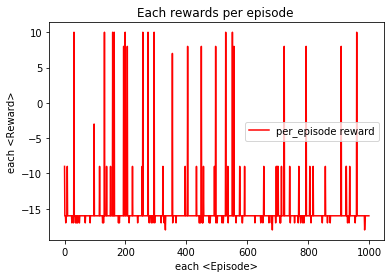


隨著 Episode 增加累積的 Reward:


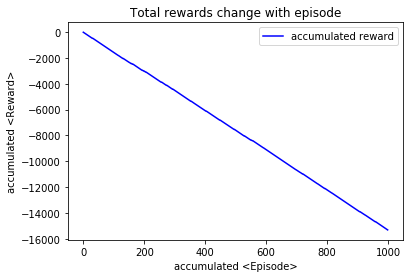


每一個 Episode 的 PPP_Reward:


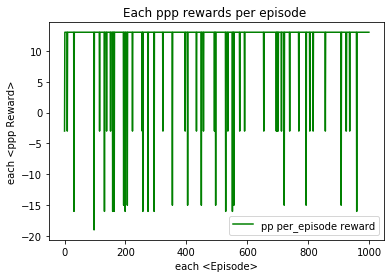


隨著 Episode 增加累積的 PPP_Reward:


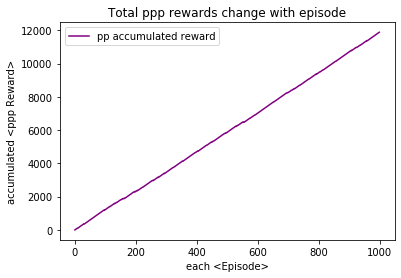


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.47555   -4.533167  -5.3942976 -3.9420412 -2.4388473]]
1 : [[-2.30892   -4.466021  -5.461357  -3.8083072 -2.2692416]]
2 : [[ -9.764854  -2.941747  -8.874179 -11.851271 -11.180675]]
3 : [[-2.3555708 -4.404257  -5.4216514 -3.8602412 -2.4515314]]
4 : [[-2.1827376 -4.400981  -5.4723063 -3.6963482 -2.201609 ]]
5 : [[ -9.303168   -2.590364   -8.324891  -11.733779  -11.6736965]]
6 : [[-2.2009087 -4.4904585 -5.5639563 -3.6926825 -1.993238 ]]
7 : [[-2.3928976 -4.390476  -5.3661957 -3.8886948 -2.5048525]]
8 : [[ -8.723519   -3.3805883  -8.421419  -10.635768   -9.749753 ]]
9 : [[-2.6862483 -4.7257    -5.3279457 -4.132991  -2.5758533]]
10 : [[-2.492352  -4.456337  -5.335887  -3.9812977 -2.6472406]]
11 : [[-10.225218   -1.7806611  -7.8837023 -13.070085  -14.211896 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.6680675  6.0937295  5.971567   5.3236494 -1.4387162]]
1 : [[ 4.9172726  7.2015066  6.338990

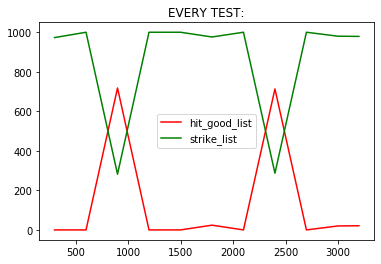

In [9]:
gd, stk, wk = tmp_test_func()
FnTest_GOOD_LIST.append(gd)
FnTest_STRIKE_LIST.append(stk)
FnTest_WALK_LIST.append(wk)
FnTest_EPS_LIST.append(episode)
print("==================================")
print("EVERY TEST:")
plt.title('EVERY TEST:')
plt.plot(FnTest_EPS_LIST, FnTest_GOOD_LIST, color='r',label = 'hit_good_list')
plt.plot(FnTest_EPS_LIST, FnTest_STRIKE_LIST, color='g',label = 'strike_list')
#plt.plot(FnTest_EPS_LIST, FnTest_WALK_LIST, color='b',label = 'walk_list')
plt.legend()
plt.show()
print("")
print("==================================")

---
#### 訓練投打
---

>>Ep: 299
test Ep: 199
test Ep: 399
test Ep: 599
test Ep: 799
test Ep: 999

使用的超參數:
agent epsilon = 0.8000000000000003
pitcher epsilon = 0.18000000000000024
gamma = 0.6
----------------------------------
hit_good_times: 45
strike_out_times : 955
walk_times    : 0
----------------------------------
total_episode: 1000
total_score  : -11738
average_score: -11.738
pp_total_score  : 11117
avg pp_total_score  : 11.117
每一個 Episode 的 Reward:


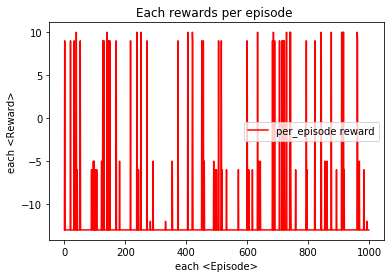


隨著 Episode 增加累積的 Reward:


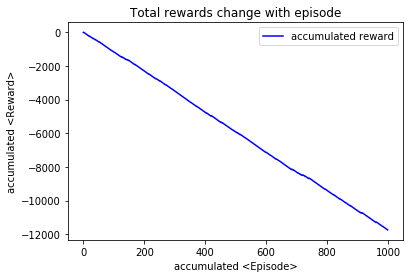


每一個 Episode 的 PPP_Reward:


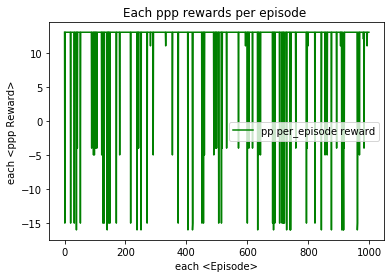


隨著 Episode 增加累積的 PPP_Reward:


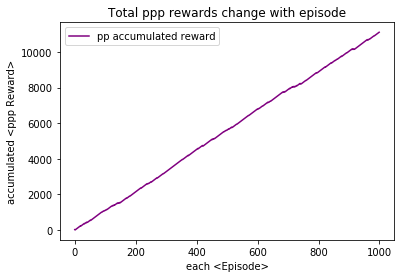


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.1358805 -3.3109941 -2.8768353 -2.8676934 -2.8083386]]
1 : [[-2.1999207 -3.2892191 -2.9084687 -2.9082167 -2.9102578]]
2 : [[-3.5149174 -6.652157  -6.7151656 -7.9127584 -9.609325 ]]
3 : [[-2.2558823 -3.1378145 -2.7918317 -2.8180933 -2.5916338]]
4 : [[-2.03002   -3.2319188 -2.704342  -2.7044668 -2.2932007]]
5 : [[ -9.137383   -1.9800828  -6.393722   -8.7536545 -10.571557 ]]
6 : [[-2.6240582 -2.629938  -2.4939237 -2.729308  -1.9948746]]
7 : [[-0.6613384 -5.0691223 -3.3718204 -3.1085753 -3.4168482]]
8 : [[ -3.7357345  -7.75359    -7.8418317  -9.366744  -11.395721 ]]
9 : [[-3.8225827 -5.3663197 -5.7970386 -6.828681  -8.211161 ]]
10 : [[-1.9080315  -2.5290196  -1.8052164  -1.9831512   0.15459502]]
11 : [[ -1.3007048  -9.793152   -8.003899   -8.975376  -11.069592 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 3.7369642  4.793104   4.757313   3.80216   -2.5026112]]
1 : [[ 3.73747    5.310033   4.8

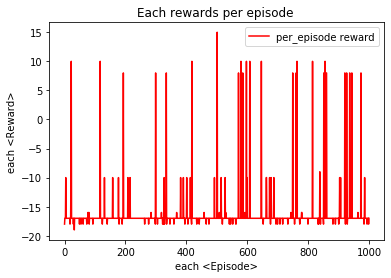


隨著 Episode 增加累積的 Reward:


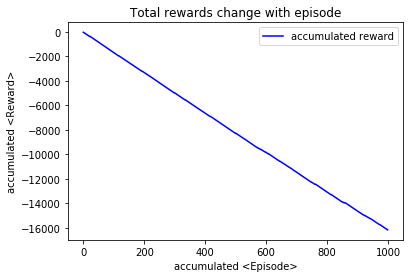


每一個 Episode 的 PPP_Reward:


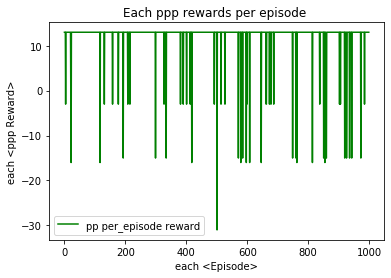


隨著 Episode 增加累積的 PPP_Reward:


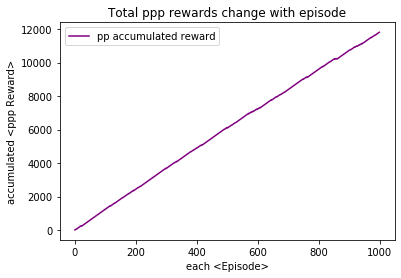


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-1.556029  -1.3503762 -2.53185   -1.9011439 -1.1652454]]
1 : [[-1.5717072 -1.3421633 -2.5262465 -1.8988848 -1.1631719]]
2 : [[ -6.601542    -0.94970274  -7.420474    -8.695422   -11.275581  ]]
3 : [[-1.4638317 -1.4248579 -2.5855355 -1.9444199 -1.3098893]]
4 : [[-1.2835118 -1.3386847 -2.3428776 -1.6529763 -0.4327675]]
5 : [[ -9.071993     0.01472414  -7.781688    -9.578196   -12.128175  ]]
6 : [[-1.4130828  -0.62574965 -2.0232942  -1.4453067   1.5987852 ]]
7 : [[-1.2248998 -1.3960729 -2.427555  -1.7252047 -0.746306 ]]
8 : [[-2.3199074 -2.3254347 -5.355191  -5.311432  -7.2350903]]
9 : [[-4.3596654 -1.0861385 -4.916068  -5.2644634 -6.4321785]]
10 : [[ 0.40222943 -1.1389143  -1.4423494  -0.3975274   3.4594176 ]]
11 : [[-0.6630858 -2.700521  -3.690493  -3.0299077 -4.2257414]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 3.8789825  4.383423   4.8268566  4.8999896 -3.1742475]]
1 : [[ 4.284686   5.40

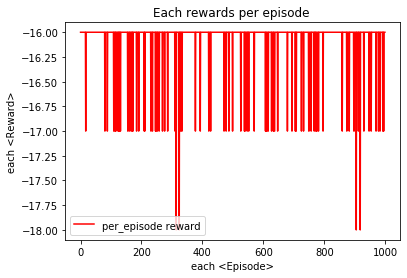


隨著 Episode 增加累積的 Reward:


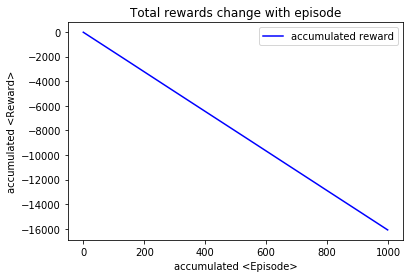


每一個 Episode 的 PPP_Reward:


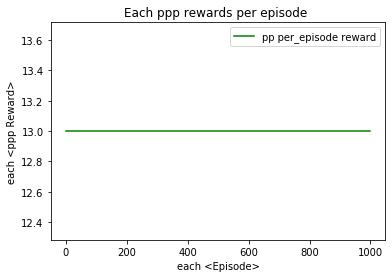


隨著 Episode 增加累積的 PPP_Reward:


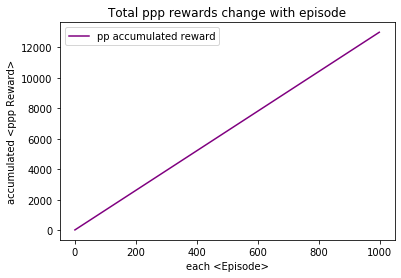


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.192647  -1.6806543 -2.3848443 -2.9650621 -3.1001859]]
1 : [[-2.7893176 -1.7154118 -2.3018374 -3.1928816 -3.7454185]]
2 : [[-10.161808   -4.3075786  -5.215719   -9.435418  -11.092114 ]]
3 : [[-2.5954518 -1.6737379 -2.2873988 -3.0740607 -3.6341434]]
4 : [[-2.2264872 -1.6047144 -2.2701225 -2.8539183 -3.416934 ]]
5 : [[-10.2207155  -4.328598   -5.237092   -9.4832325 -11.1313505]]
6 : [[-2.1354616 -1.6577972 -2.3984823 -2.8763816 -3.2529783]]
7 : [[-2.5839539 -1.6916486 -2.250984  -3.0573711 -3.3648138]]
8 : [[-8.517061 -3.7405   -4.563901 -8.083977 -9.372189]]
9 : [[-2.5936105 -1.6894723 -2.2740092 -3.0485923 -3.511221 ]]
10 : [[-2.0786045 -1.5497735 -2.3905373 -2.7657943 -4.1609645]]
11 : [[-8.455247  -3.6654158 -4.164744  -8.111383  -8.40254  ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.5243053  4.6862445  5.1388474  5.545062  -2.888257 ]]
1 : [[ 4.7586226  6.7887897  5.7342863  7.00941

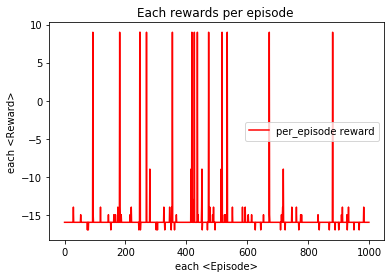


隨著 Episode 增加累積的 Reward:


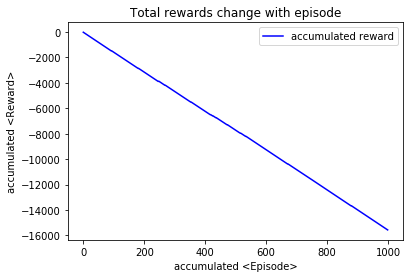


每一個 Episode 的 PPP_Reward:


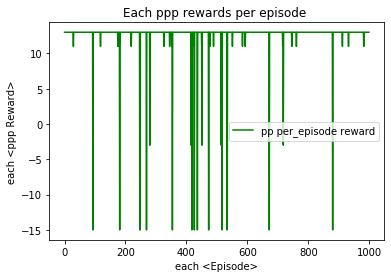


隨著 Episode 增加累積的 PPP_Reward:


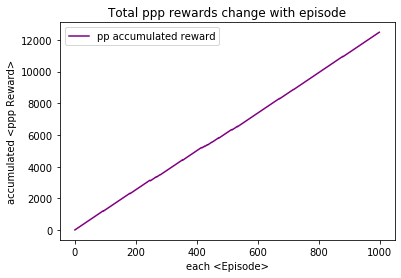


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.3754053 -2.5377476 -2.4717312 -3.758119  -2.5086117]]
1 : [[-2.6671758 -2.710606  -2.512302  -3.8207946 -2.4984531]]
2 : [[ -9.249613   -6.9716206  -2.7172928 -13.106239  -10.538046 ]]
3 : [[-2.4110386 -2.6762366 -2.5469072 -3.576099  -2.0799096]]
4 : [[-2.755402  -2.7873638 -2.5266159 -3.8316264 -2.4510398]]
5 : [[ -9.280436   -7.0072217  -2.6905472 -13.087126  -10.605691 ]]
6 : [[-1.7717857  -2.16044    -2.8534908  -3.7222328  -0.92789686]]
7 : [[-3.7444465 -2.8179543 -2.4231122 -3.9550505 -3.5234823]]
8 : [[-7.8871427 -4.8453913 -1.7256207 -3.088146  -6.129886 ]]
9 : [[-1.5657641 -2.0230775 -2.6609514 -3.5541053 -2.0457428]]
10 : [[-1.4610355 -2.1404936 -2.6233082 -3.2689693 -1.6086859]]
11 : [[-10.372313   -7.6438813  -2.2799666 -13.937388  -12.7316065]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.3280215  3.1016397  5.03548    4.6773243 -0.7157551]]
1 : [[ 4.5764747  3.4874086  5.1

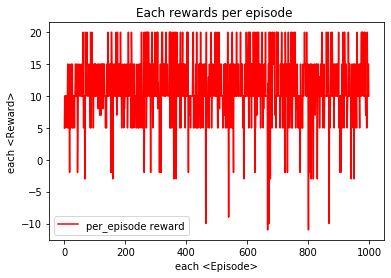


隨著 Episode 增加累積的 Reward:


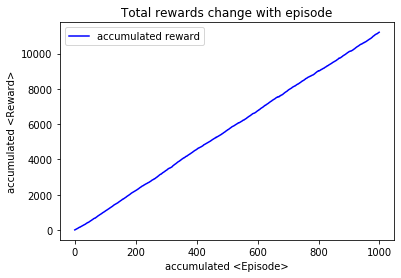


每一個 Episode 的 PPP_Reward:


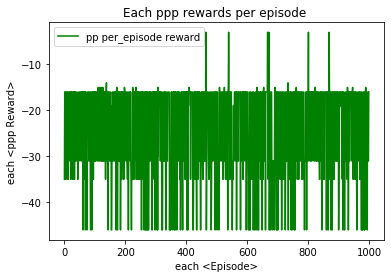


隨著 Episode 增加累積的 PPP_Reward:


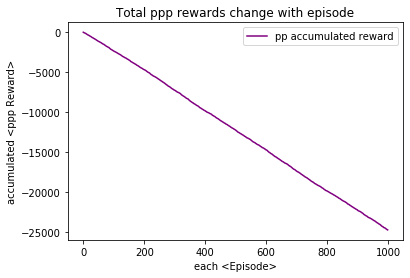


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-1.7732185 -3.7960577 -2.93624   -0.6921339 -1.9287596]]
1 : [[-2.1656046 -4.0897517 -3.0187662 -0.7467787 -2.692012 ]]
2 : [[ -8.701047 -13.362751  -3.948591 -10.71231  -12.113081]]
3 : [[-2.007173  -3.9206572 -2.9378822 -0.743083  -2.223737 ]]
4 : [[-3.3629217 -5.073058  -3.4383333 -2.5476067 -5.021783 ]]
5 : [[-5.0682135 -5.975077  -3.978857  -4.9689274 -8.553094 ]]
6 : [[-1.2501106 -3.4111862 -2.8115766 -0.5783844 -0.8618762]]
7 : [[-2.5726209 -4.4082603 -3.1057181 -1.0062118 -3.4907985]]
8 : [[-4.019113  -5.513033  -3.5781114 -3.545283  -6.291968 ]]
9 : [[-1.6050625  -3.7544262  -2.9423163  -0.21487212 -1.6555892 ]]
10 : [[-3.6342318 -6.1058245 -3.25069   -2.721372  -4.9017158]]
11 : [[-3.7730677 -5.0741253 -3.5153131 -2.9333565 -6.16235  ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.1048346   0.96193707  4.290644    4.712273   -1.5361419 ]]
1 : [[ 4.32458     0.8933495   4.4680223  

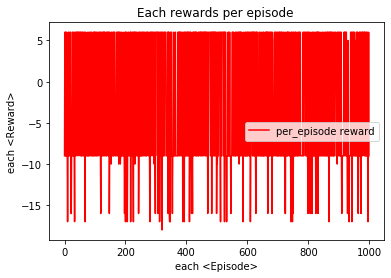


隨著 Episode 增加累積的 Reward:


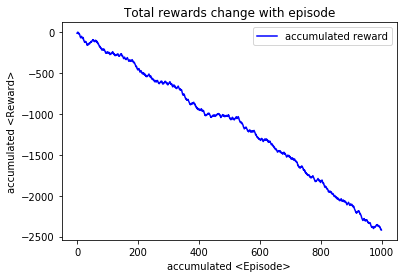


每一個 Episode 的 PPP_Reward:


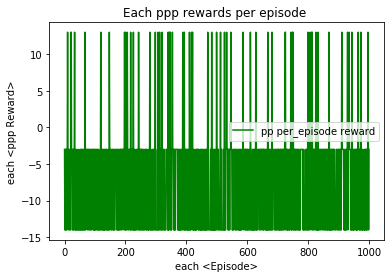


隨著 Episode 增加累積的 PPP_Reward:


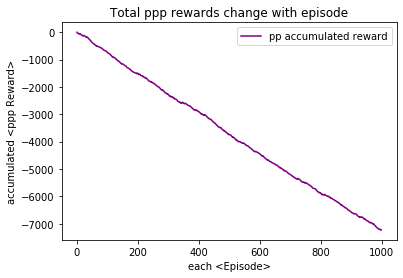


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.2407916 -2.255253  -4.1495867 -1.3856671 -3.5354664]]
1 : [[-2.4128592 -2.4628336 -4.2321243 -1.6823862 -3.953419 ]]
2 : [[-6.093895  -2.7454433 -5.6959453 -6.3431983 -9.6902895]]
3 : [[-2.237131  -2.5676942 -4.179495  -1.6048307 -3.6241508]]
4 : [[-2.3662415 -2.370438  -4.214247  -1.5408609 -3.7798457]]
5 : [[-3.7574894 -1.7849563 -4.5375605 -2.9661825 -7.6147785]]
6 : [[-1.5400345  -2.1211996  -3.8069878  -0.74469185 -2.3655598 ]]
7 : [[-2.285563  -2.6286883 -4.195245  -1.6443849 -3.8285902]]
8 : [[-2.4042706 -2.0405743 -4.2179494 -1.2289008 -3.7251048]]
9 : [[-2.078208  -2.4522233 -4.0727296 -1.3063405 -3.3865454]]
10 : [[-2.48616   -2.4462285 -4.249129  -1.8302369 -4.2496815]]
11 : [[-4.9739323 -2.3712916 -4.9612875 -4.857954  -9.94285  ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 5.2130356  4.8645425  5.4945316  2.7160609 -2.4213977]]
1 : [[ 5.325625   5.2107015  5.916296   3.10280

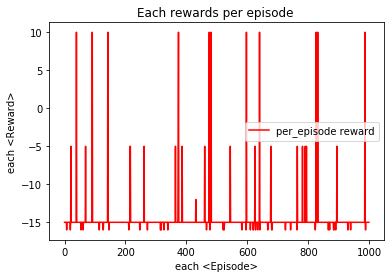


隨著 Episode 增加累積的 Reward:


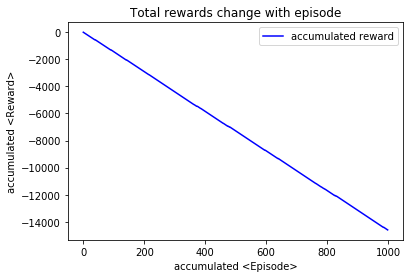


每一個 Episode 的 PPP_Reward:


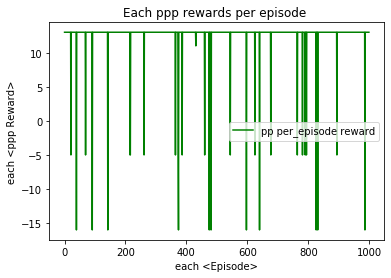


隨著 Episode 增加累積的 PPP_Reward:


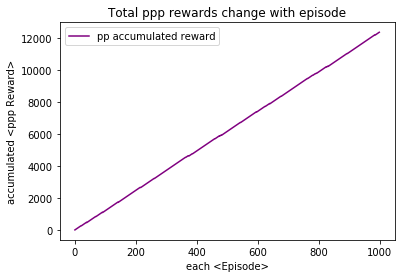


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-2.4163568 -3.0948575 -6.113102  -2.6695166 -2.9257836]]
1 : [[-3.0270681 -3.4434307 -6.518275  -2.7605543 -4.3247356]]
2 : [[ -8.772949  -4.373632 -10.861275 -12.113822 -11.003524]]
3 : [[-2.5839584 -3.3672621 -6.228375  -2.71764   -3.515717 ]]
4 : [[-3.0476825 -3.5848997 -6.61894   -2.8304605 -4.5384674]]
5 : [[ -8.957717   -4.3552303 -10.980978  -12.2287035 -11.273136 ]]
6 : [[-2.815381  -3.599225  -6.382695  -2.5053215 -4.699446 ]]
7 : [[-3.033179  -3.1605513 -6.435125  -3.111517  -3.4708862]]
8 : [[ -8.813526  -4.252407 -10.834777 -11.989045 -11.018903]]
9 : [[-3.3913734 -4.0647383 -6.68881   -2.5039365 -5.9996367]]
10 : [[-2.6750536 -2.9171631 -6.2388268 -2.9377766 -2.9585588]]
11 : [[ -8.907357   -4.2877755 -10.905684  -12.13804   -11.132661 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 3.979073   4.588601   4.9881415  2.360574  -3.6398184]]
1 : [[ 4.9176874  5.3817663  6.028916   2.

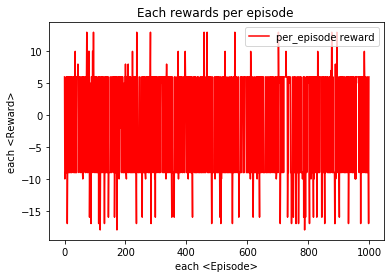


隨著 Episode 增加累積的 Reward:


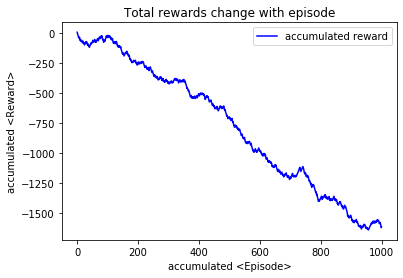


每一個 Episode 的 PPP_Reward:


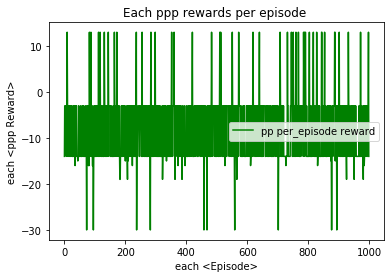


隨著 Episode 增加累積的 PPP_Reward:


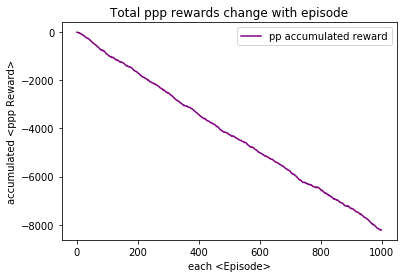


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-3.155993  -4.0962076 -4.6905613 -4.5688    -3.1168983]]
1 : [[-3.366825  -4.2737007 -4.6567674 -4.552722  -3.3089454]]
2 : [[-5.057255  -6.3133564 -4.9245367 -3.9375277 -5.94355  ]]
3 : [[-2.909071  -3.7519305 -4.740118  -4.716158  -2.587251 ]]
4 : [[-3.351531  -4.303237  -4.677415  -4.518064  -3.3658223]]
5 : [[-5.6277485 -7.1076107 -5.2358513 -3.5551744 -6.8077927]]
6 : [[-3.4091048 -4.1742697 -4.7802753 -4.746543  -3.0952306]]
7 : [[ -8.453314   -7.3086815  -7.890463  -14.335867   -9.990729 ]]
8 : [[-10.624325   -8.546231   -8.6858425 -17.859022  -12.396555 ]]
9 : [[-3.6878452 -4.485549  -4.6887493 -4.682062  -3.4433157]]
10 : [[-3.5048065 -4.464616  -4.5684195 -4.464576  -3.6117942]]
11 : [[-12.122228  -9.663129  -9.802577 -20.33085  -14.235062]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 5.0448675  4.5145245  6.1848626  5.9756527 -3.0649302]]
1 : [[ 5.532159   5.4287176  7.4419613  6.

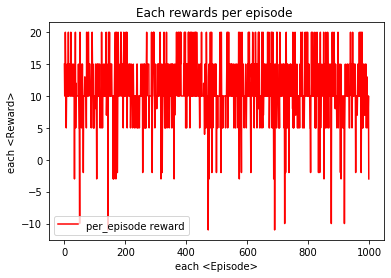


隨著 Episode 增加累積的 Reward:


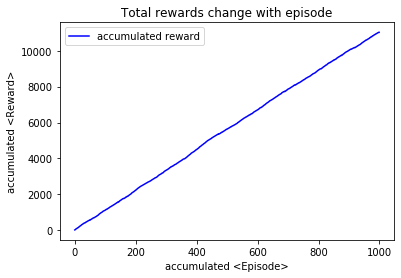


每一個 Episode 的 PPP_Reward:


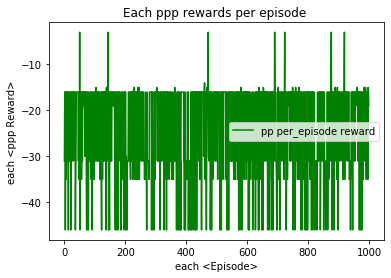


隨著 Episode 增加累積的 PPP_Reward:


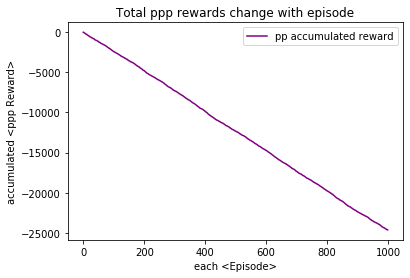


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[ 0.09675527 -3.7947533   2.7043529  -0.8740069   0.04846716]]
1 : [[-1.3617408 -4.457553   1.5740428 -0.9540378 -1.53453  ]]
2 : [[-6.6351094 -7.4866    -1.379175  -1.4639361 -7.7666693]]
3 : [[ 0.71992874 -3.5019774   2.899864   -0.8870753   0.59680724]]
4 : [[-0.90531516 -4.24125     1.7657409  -0.928027   -0.989259  ]]
5 : [[-6.648495  -7.470459  -1.4548495 -1.5622078 -7.824052 ]]
6 : [[ 0.02641535 -3.8090596   2.4905934  -0.8141384   0.12846231]]
7 : [[-0.18498874 -3.8788567   2.1588807  -0.6899885   0.3262005 ]]
8 : [[-6.559115  -7.3975863 -1.457209  -1.580657  -7.7148714]]
9 : [[-0.20086002 -3.9087303   2.2082133  -0.9175364  -0.257823  ]]
10 : [[-1.9614972  -4.7987027   1.1023433  -0.85398704 -1.9606667 ]]
11 : [[ -9.302851   -9.169193   -2.2447305  -1.8721817 -11.036168 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 3.4448469  3.7866461  4.63514    4.1967936 -3.1356165]]
1 : [[ 3.808

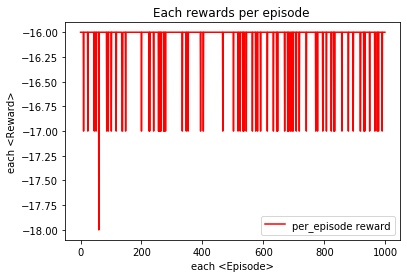


隨著 Episode 增加累積的 Reward:


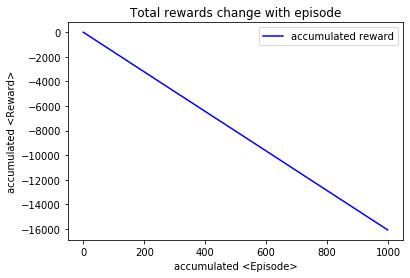


每一個 Episode 的 PPP_Reward:


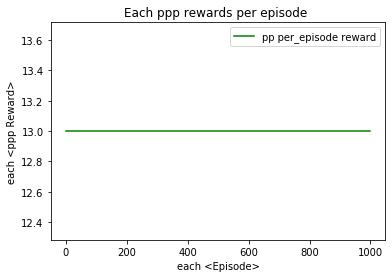


隨著 Episode 增加累積的 PPP_Reward:


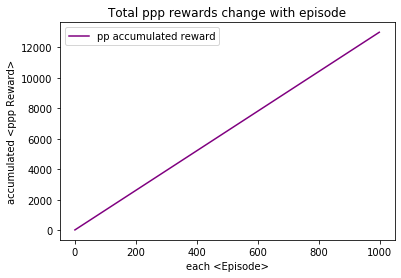


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[ -1.8636003 -11.783554   -1.0092369  -3.136958   -1.6267345]]
1 : [[ -2.2238047 -11.542653   -1.126795   -3.15733    -2.0147126]]
2 : [[-7.2124453 -8.813868  -3.402309  -4.077568  -7.360732 ]]
3 : [[ -2.1687727 -11.57383    -1.0764058  -3.1689134  -1.9654689]]
4 : [[ -1.4229262  -12.004341    -0.75208974  -3.1110682   -1.3118067 ]]
5 : [[-6.930445  -8.838696  -3.2354736 -3.931699  -7.0459538]]
6 : [[ -2.4815617 -11.281204   -1.1832794  -3.2204509  -2.3200161]]
7 : [[ -1.8782251  -11.5587635   -0.61656183  -3.6817627   -1.7314408 ]]
8 : [[-7.9415417 -8.700232  -3.8396356 -4.401212  -8.172049 ]]
9 : [[ -2.3689935  -11.327871    -0.98397356  -3.3288212   -2.2303824 ]]
10 : [[ -3.9744992 -10.436605   -1.8604224  -3.413015   -3.9584584]]
11 : [[ -9.743449  -8.643428  -4.951358  -5.253506 -10.086875]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 4.1474314  4.1417656  3.601559   4.6861362 -0.5435965

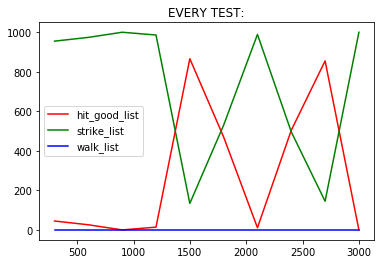

In [8]:
is_b_close = False
is_p_close = False

train_episodes = 3200
test_eps_gap = 300
batch_size = 32
timesteps_per_episode = 100

total_score = 0
pp_total_score = 0

hit_good_times = 0
strike_out_times = 0
walk_times = 0

FnTest_GOOD_LIST = []
FnTest_STRIKE_LIST = []
FnTest_WALK_LIST = []
FnTest_EPS_LIST = []

#per_episode_reward_list = []
#accumulate_reward_list = []
#pp_per_episode_reward_list = []
#pp_accumulate_reward_list = []
#hit_good_list = []
#strike_list = []
#walk_list = []
#accumulate_episode_list = []

for episode in range(0, train_episodes):
    # Reset the enviroment
    state = enviroment.reset()
    state = np.reshape(state, [1, 1])
    
    # Initialize variables
    episode_reward = 0
    pp_episode_reward = 0
    reward = 0
    p_reward = 0
    terminated = False
    
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(state, close_epsilon=is_b_close)
        p_action = new_pitcher.act(state, close_epsilon=is_p_close)
        
        # Take action
        next_state, reward, p_reward, terminated, info = enviroment.step(action, p_action) 
        next_state = np.reshape(next_state, [1, 1])
        if(not is_b_close):
            agent.store(state, action, reward, next_state, terminated)
        if(not is_p_close):
            new_pitcher.store(state, p_action, p_reward, next_state, terminated)
        
        state = next_state
        episode_reward += reward
        pp_episode_reward += p_reward
                
        if terminated:
            if(not is_b_close):
                agent.alighn_target_model()
            if(not is_p_close):
                new_pitcher.alighn_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            if(not is_b_close):
                agent.retrain(batch_size)
            if(not is_p_close):
                new_pitcher.retrain(batch_size)
    
    if info == 'Hit-good':
        agent.change_eps(ch_up = False)
        new_pitcher.change_eps(ch_up = True)
        hit_good_times += 1
    elif info == 'StrikeOut':
        agent.change_eps(ch_up = True)
        new_pitcher.change_eps(ch_up = False)
        strike_out_times += 1
    elif info == 'Walk':
        agent.change_eps(ch_up = False)
        new_pitcher.change_eps(ch_up = True)
        walk_times += 1
        
    total_score += episode_reward
    pp_total_score += pp_episode_reward
    
    #per_episode_reward_list.append(episode_reward)
    #accumulate_reward_list.append(total_score)
    #pp_per_episode_reward_list.append(pp_episode_reward)
    #pp_accumulate_reward_list.append(pp_total_score)
    
    #hit_good_list.append(hit_good_times)
    #strike_list.append(strike_out_times)
    #walk_list.append(walk_times)
    
    #accumulate_episode_list.append(episode)
    
    if (episode +1) % test_eps_gap == 0:
        print(">>Ep:", episode)
        '''
        print("=================================================")
        print("怕甲 Bat")
        print("i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL")
        agent.CS_poker_face()
        print("=================================================")
        print("披甲 Pch")
        print("i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL")
        new_pitcher.CS_poker_face()
        print("=================================================")
        '''
        ### ad some test
        gd, stk, wk = tmp_test_func()
        FnTest_GOOD_LIST.append(gd)
        FnTest_STRIKE_LIST.append(stk)
        FnTest_WALK_LIST.append(wk)
        FnTest_EPS_LIST.append(episode)
        ###

print("=================================================")
print("END WHOLE")
print("=================================================")
print("")
print("使用的超參數:")
print("agent epsilon =", agent.epsilon)
print("pitcher epsilon =", new_pitcher.epsilon)
print("gamma =", agent.gamma)
print("")

print("----------------------------------")
print("hit_good_times:", hit_good_times)
print("strike_out_times :", strike_out_times)
print("walk_times    :", walk_times)
print("----------------------------------")
print("total_episode:", (episode+1))
print("total_score  :", total_score)
print("average_score:", total_score/(episode+1))
print("----------------------------------")
print("")

'''
print("每一個 Episode 的 Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <Reward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, per_episode_reward_list, color='r',label = 'per_episode reward')
plt.legend()
plt.show()
print("")

print("隨著 Episode 增加累積的 Reward:")
plt.xlabel('accumulated <Episode>')
plt.ylabel('accumulated <Reward>')
plt.title('Total rewards change with episode')
plt.plot(accumulate_episode_list, accumulate_reward_list, color='b',label = 'accumulated reward')
plt.legend()
plt.show()
print("")

print("每一個 Episode 的 PPP_Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <ppp Reward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, pp_per_episode_reward_list, color='g',label = 'pp per_episode reward')
plt.legend()
plt.show()
print("")

print("隨著 Episode 增加累積的 PPP_Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <ppp accReward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, pp_accumulate_reward_list, color='purple',label = 'pp accumulated reward')
plt.legend()
plt.show()
print("")


print("每一個......................:")
plt.xlabel('each <Episode>')
plt.ylabel('each <For Fun>')
plt.title('aaaaaaaaaaaaaaaaaaaaaa')
plt.plot(accumulate_episode_list, hit_good_list, color='r',label = 'hit_good_list')
plt.plot(accumulate_episode_list, strike_list, color='g',label = 'strike_list')
plt.plot(accumulate_episode_list, walk_list, color='b',label = 'walk_list')
plt.legend()
plt.show()
print("")
'''

print("==================================")
print("EVERY TEST:")
plt.title('EVERY TEST:')
plt.plot(FnTest_EPS_LIST, FnTest_GOOD_LIST, color='r',label = 'hit_good_list')
plt.plot(FnTest_EPS_LIST, FnTest_STRIKE_LIST, color='g',label = 'strike_list')
plt.plot(FnTest_EPS_LIST, FnTest_WALK_LIST, color='b',label = 'walk_list')
plt.legend()
plt.show()
print("")


test Ep: 199
test Ep: 399
test Ep: 599
test Ep: 799
test Ep: 999

使用的超參數:
agent epsilon = 0.8000000000000003
pitcher epsilon = 0.18000000000000538
gamma = 0.6
----------------------------------
hit_good_times: 0
strike_out_times : 1000
walk_times    : 0
----------------------------------
total_episode: 1000
total_score  : -14990
average_score: -14.99
pp_total_score  : 12938
avg pp_total_score  : 12.938
每一個 Episode 的 Reward:


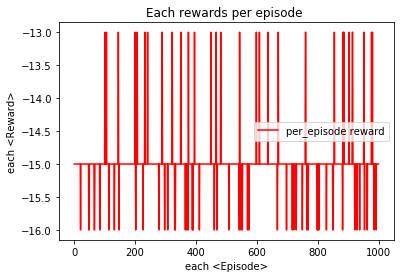


隨著 Episode 增加累積的 Reward:


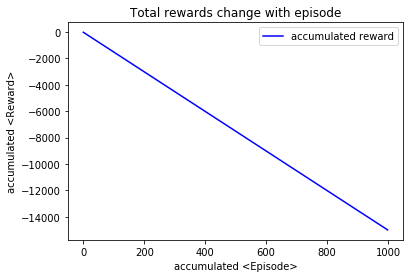


每一個 Episode 的 PPP_Reward:


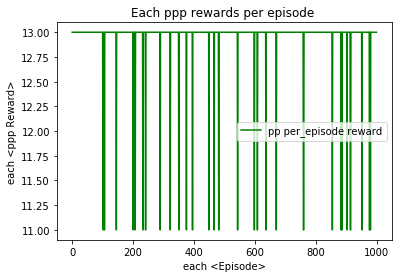


隨著 Episode 增加累積的 PPP_Reward:


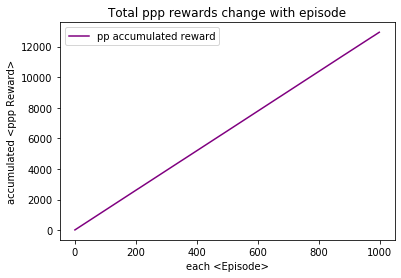


怕甲 Bat
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-3.0152607 -6.9155946 -3.075902  -4.310299  -3.3247945]]
1 : [[-4.2173715 -6.9112854 -3.5762267 -4.6937337 -4.4127383]]
2 : [[-10.376093  -6.765099  -8.530708  -8.302652 -10.506308]]
3 : [[-4.6504097 -6.9190116 -3.6828556 -4.8809485 -4.855961 ]]
4 : [[-4.1086435 -6.8983774 -3.776043  -4.81374   -4.473176 ]]
5 : [[-9.69314  -6.805459 -7.57907  -7.680705 -9.591639]]
6 : [[-3.627036 -6.907504 -3.172478 -4.566856 -3.922261]]
7 : [[-3.7388096 -6.902605  -3.3800206 -4.6022477 -4.0381584]]
8 : [[-10.732807  -6.862669  -8.920003  -8.420756 -11.365808]]
9 : [[-4.329039  -6.906701  -3.0871048 -4.969509  -4.7120395]]
10 : [[-4.5794406 -6.920919  -3.640263  -4.736433  -4.622122 ]]
11 : [[-13.1211605  -6.672609  -10.571039  -10.465567  -13.487116 ]]
披甲 Pch
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 5.217232   5.7754097  1.9829046  6.221908  -2.1151867]]
1 : [[ 5.486283   5.815122   2.9056108  6.973626  -2.0017

In [9]:
gd, stk, wk = tmp_test_func()
FnTest_GOOD_LIST.append(gd)
FnTest_STRIKE_LIST.append(stk)
FnTest_WALK_LIST.append(wk)
FnTest_EPS_LIST.append(episode)

EVERY TEST:


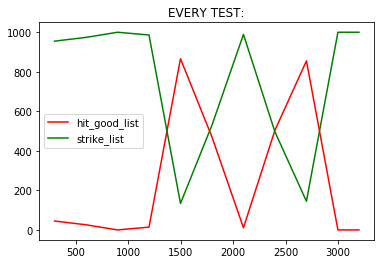

In [10]:
print("==================================")
print("EVERY TEST:")
plt.title('EVERY TEST:')
plt.plot(FnTest_EPS_LIST, FnTest_GOOD_LIST, color='r',label = 'hit_good_list')
plt.plot(FnTest_EPS_LIST, FnTest_STRIKE_LIST, color='g',label = 'strike_list')
#plt.plot(FnTest_EPS_LIST, FnTest_WALK_LIST, color='b',label = 'walk_list')
plt.legend()
plt.show()
print("")
print("==================================")

In [15]:
#[0B0S, 0B1S, 0B2S, 
# 1B0S, 1B1S, 1B2S, 
# 2B0S, 2B1S, 2B2S, 
# 3B0S, 3B1S, 3B2S]
print("=================================================")
print("怕甲 Bat")
print("i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL")
agent.CS_poker_face()
print("=================================================")
print("披甲 Pch")
print("i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL")
new_pitcher.CS_poker_face()
print("=================================================")

agent
i : hold   Swing_IH   Swing_IL   Swing_OH   Swing_OL
0 : [[-3.4175901 -4.914077  -7.743558  -7.146813  -2.9622588]]
1 : [[-3.6520286 -5.010977  -7.6079907 -7.292306  -3.9591706]]
2 : [[ -8.784384  -8.188853 -12.951115 -13.343863 -10.359466]]
3 : [[-3.6729782 -4.6121135 -7.2412634 -6.9646    -4.156868 ]]
4 : [[-3.6525345 -5.144412  -7.7267075 -7.3637714 -3.8463655]]
5 : [[ -8.776702  -8.230575 -12.890406 -13.320488 -10.452566]]
6 : [[-3.3571668 -4.134859  -7.4366493 -6.3968434 -1.9160857]]
7 : [[-3.81554   -4.308218  -7.4478383 -6.7950964 -3.7128568]]
8 : [[ -7.2664127  -7.125391  -11.623116  -11.705208   -8.165863 ]]
9 : [[-3.5222955 -5.0058002 -7.6981616 -7.2366695 -3.4553864]]
10 : [[-5.54881   -6.3377614 -9.867397  -9.764013  -6.1767607]]
11 : [[ -9.252017  -8.512264 -13.928286 -14.108334 -10.293835]]
披甲
i : B_ball   G_ball_IH   G_ball_IL   G_ball_OH   G_ball_OL
0 : [[ 5.1164923e+00  6.1848392e+00  1.3408661e-03  4.9706635e+00
  -4.2182393e+00]]
1 : [[ 5.3483253   6.3483124  -

#### 都不訓練，直接上場

Ep: 51
Ep: 151
Ep: 251
Ep: 351
Ep: 451
Ep: 551
Ep: 651
Ep: 751
Ep: 851
Ep: 951

使用的超參數:
epsilon = 0.8000000000000003
gamma = 0.6

----------------------------------
hit_good_times: 21
strike_out_times : 979
walk_times    : 0
----------------------------------
total_episode: 1000
total_score  : -15352
average_score: -15.352
----------------------------------

每一個 Episode 的 Reward:


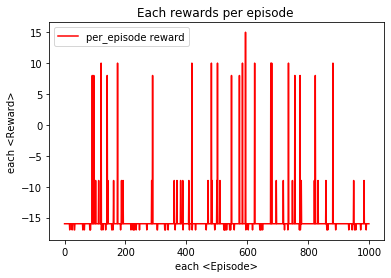


隨著 Episode 增加累積的 Reward:


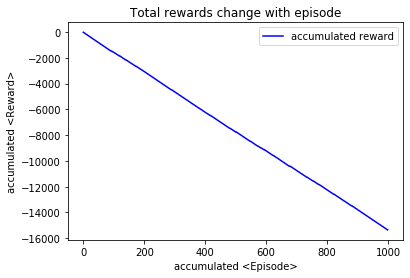


每一個 Episode 的 PPP_Reward:


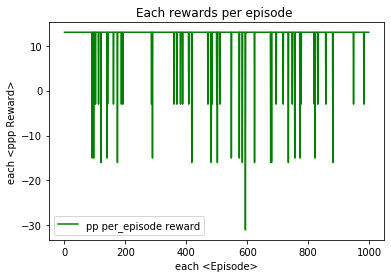


隨著 Episode 增加累積的 PPP_Reward:


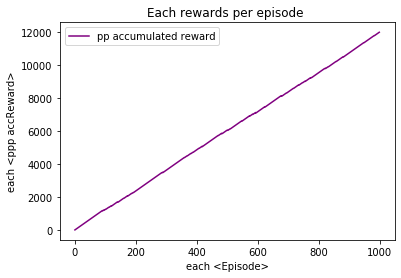


每一個......................:


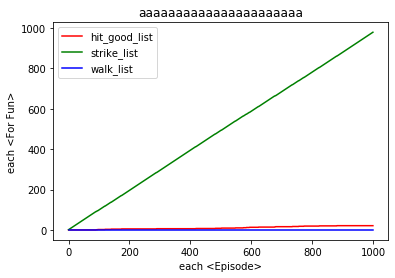

In [10]:
is_b_close = True
is_p_close = True

batch_size = 32
test_episodes = 1000
timesteps_per_episode = 100

total_score = 0
pp_total_score = 0

hit_good_times = 0
strike_out_times = 0
walk_times = 0

per_episode_reward_list = []
accumulate_reward_list = []
accumulate_episode_list = []
pp_per_episode_reward_list = []
pp_accumulate_reward_list = []
hit_good_list = []
strike_list = []
walk_list = []

for episode in range(0, test_episodes):
    # Reset the enviroment
    state = enviroment.reset()
    state = np.reshape(state, [1, 1])
    
    # Initialize variables
    episode_reward = 0
    pp_episode_reward = 0
    reward = 0
    p_reward = 0
    terminated = False
    
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(state, close_epsilon=is_b_close)
        p_action = new_pitcher.act(state, close_epsilon=is_p_close)
        
        # Take action
        next_state, reward, p_reward, terminated, info = enviroment.step(action, p_action) 
        next_state = np.reshape(next_state, [1, 1])
        if(not is_b_close):
            agent.store(state, action, reward, next_state, terminated)
        if(not is_p_close):
            new_pitcher.store(state, p_action, p_reward, next_state, terminated)
        
        state = next_state
        episode_reward += reward
        pp_episode_reward += p_reward
        
        if terminated:
            if(not is_b_close):
                agent.alighn_target_model()
            if(not is_p_close):
                new_pitcher.alighn_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            if(not is_b_close):
                agent.retrain(batch_size)
            if(not is_p_close):
                new_pitcher.retrain(batch_size)
    
    if info == 'Hit-good':
        hit_good_times += 1
    elif info == 'StrikeOut':
        strike_out_times += 1
    elif info == 'Walk':
        walk_times += 1
        
    total_score += episode_reward
    pp_total_score += pp_episode_reward
    
    per_episode_reward_list.append(episode_reward)
    accumulate_reward_list.append(total_score)
    
    pp_per_episode_reward_list.append(pp_episode_reward)
    pp_accumulate_reward_list.append(pp_total_score)
    
    hit_good_list.append(hit_good_times)
    strike_list.append(strike_out_times)
    walk_list.append(walk_times)

    accumulate_episode_list.append(episode)
    
    if (episode + 49) % 100 == 0:
        print("Ep:", episode)


print("")
print("使用的超參數:")
print("epsilon =", agent.epsilon)
#print("learning rate =", agent.lr_rate)
print("gamma =", agent.gamma)
print("")

print("----------------------------------")
print("hit_good_times:", hit_good_times)
print("strike_out_times :", strike_out_times)
print("walk_times    :", walk_times)
print("----------------------------------")
print("total_episode:", (episode+1))
print("total_score  :", total_score)
print("average_score:", total_score/(episode+1))
print("----------------------------------")
print("")

print("每一個 Episode 的 Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <Reward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, per_episode_reward_list, color='r',label = 'per_episode reward')
plt.legend()
plt.show()
print("")

print("隨著 Episode 增加累積的 Reward:")
plt.xlabel('accumulated <Episode>')
plt.ylabel('accumulated <Reward>')
plt.title('Total rewards change with episode')
plt.plot(accumulate_episode_list, accumulate_reward_list, color='b',label = 'accumulated reward')
plt.legend()
plt.show()
print("")

print("每一個 Episode 的 PPP_Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <ppp Reward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, pp_per_episode_reward_list, color='g',label = 'pp per_episode reward')
plt.legend()
plt.show()
print("")

print("隨著 Episode 增加累積的 PPP_Reward:")
plt.xlabel('each <Episode>')
plt.ylabel('each <ppp accReward>')
plt.title('Each rewards per episode ')
plt.plot(accumulate_episode_list, pp_accumulate_reward_list, color='purple',label = 'pp accumulated reward')
plt.legend()
plt.show()
print("")

print("每一個......................:")
plt.xlabel('each <Episode>')
plt.ylabel('each <For Fun>')
plt.title('aaaaaaaaaaaaaaaaaaaaaa')
plt.plot(accumulate_episode_list, hit_good_list, color='r',label = 'hit_good_list')
plt.plot(accumulate_episode_list, strike_list, color='g',label = 'strike_list')
plt.plot(accumulate_episode_list, walk_list, color='b',label = 'walk_list')
plt.legend()
plt.show()
print("")

print("==================================")
